# <center> Matrix factorization</center>

<img src='https://res.cloudinary.com/practicaldev/image/fetch/s--CkIitkUF--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://thepracticaldev.s3.amazonaws.com/i/uvnamstr07nj1c9lb5br.png' width=700>

План семинара:
- SVD разложение и визуализация числа компонент
- SVD для рекомендаций
- TruncatedSVD
- TSNE визуализация

In [2]:
import warnings
warnings.filterwarnings("ignore")

from math import sqrt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import scipy as sp
import scipy.sparse as scs
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import svd
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from PIL import Image
from ipywidgets import interact, widgets

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (12, 10)
np.set_printoptions(2, suppress=True)
plt.rcParams.update({'font.size': 14})

### Что такое MF

**Матричная факторизация** (Matrix Factorization, MF) - это матричное разложение из линейной алгебры, которое является простой моделью латентных эмбеддингов. 

Будем раскладывать исходную матрицу интеракций $A$ на несколько матриц (обычно их 2 или 3), которые будут ее аппроксимировать при перемножении $ PQ^T$. Таким образом:

* Матрица интеракций $A \in R^{m \times n} $ <br>
* Матрица эмбеддингов пользователей $P \in R^{m \times dim}$, где ряд $i$ - это эмбеддинг пользователя $i$. <br>
* Матрица эмбеддингов айтемов $Q \in R^{n \times dim}$, где ряд $j$ - это эмбеддинг айтема $j$.

Пара $(i, j)$ в $PQ^T$ - это просто скалярное произведение $<P_i, Q_j>$ эмбедднигов пользователя i и айтема j, которое должно быть близко к $A_{ij}$

**Определение целевой функции для MF**

Одной из интуитивно понятных целевых функций для MF является квадрат расстояния. Для этого минимизируйте сумму квадратов ошибок по всем парам наблюдаемых записей: 

$$min_{P \in R^{m\times d}, Q \in R^{n\times d}} \sum_{(i,j) \in obs} (A_{ij} - <P_i, Q_j>)^2$$

Вы можете решать эту квадратичную задачу с помощью сингулярного разложения матрицы (SVD). Однако SVD тоже не лучшее решение, потому что на практике матрица может быть очень разреженной. Например, подумайте сколько может быть просмотрено конкретным пользователем видео на YouTube из всего их множества. Решение (соответствующее аппроксимации входной матрицы моделью), скорее всего, будет близко к нулю, что тоже приведет к плохой обобщающей способности.

**Что же тогда делать?** 

## SVD 

<img src='https://www.dataminingapps.com/wp-content/uploads/2020/02/svd2.png'>

SVD, помимо скалярного произведения, включает еще смещения по пользователю $b_u$ и объекту $b_i$. Предполагается, что смещения пользователей отражают тенденцию некоторых пользователей оценивать товары выше (или ниже) среднего. То же самое касается товаров: некоторые товары обычно оцениваются выше, чем некоторые другие. Модель SVD тогда выглядит следующим образом:

$$\hat r_{u,i} = \mu + b_u + b_i + q_{i}^{T}p_{u},$$

где $\mu$ - глобальное среднее по всем оценкам в данных. Тогда задача оптимизации сводится к:

$$ \sum(r_{u,i} - \hat r_{u,i}) ^ 2 +     \lambda(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2),$$

где $\lambda$ - параметр регуляризации.

Оптимизация через стохастический градиентный спуск:

$$b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u)$$
$$b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i)$$  
$$p_u \leftarrow p_u + \gamma (e_{ui} \cdot q_i - \lambda p_u)$$
$$q_i \leftarrow q_i + \gamma (e_{ui} \cdot p_u - \lambda q_i),$$

где $\gamma$ - это learning rate, <br>
$e_{ui} =  r_{ui} - \hat r_{u,i} = r_{u,i} - (\mu + b_u + b_i + q_{i}^{T}p_{u})$ ошибка алгоритма на паре $(u, i)$.

In [3]:
A = np.zeros((20, 5))
non_zero_count = int(A.size * 0.2)
non_zero_indices = np.random.choice(A.size, non_zero_count, replace=False)
A.ravel()[non_zero_indices] = np.random.randint(0, 5, non_zero_count)
A

array([[0., 0., 0., 3., 0.],
       [0., 0., 0., 2., 2.],
       [0., 0., 3., 0., 2.],
       [0., 0., 4., 0., 0.],
       [0., 0., 0., 0., 0.],
       [4., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 2., 0., 3., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 4., 0.],
       [0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [6]:
U, s, V = svd(A)
U.shape, s.shape, V.shape

((20, 20), (5,), (5, 5))

s - одномерный массив с сингулярными значениями. Сингулярные значения в этом массиве упорядочены в порядке убывания.

In [7]:
S = np.zeros(A.shape)
S[:len(s), :len(s)] = np.diag(s)
S

array([[6.42, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 5.18, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 4.05, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 2.68, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 2.31],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ]])

In [8]:
U @ S @ V

array([[-0.,  0.,  0.,  3., -0.],
       [-0.,  0.,  0.,  2.,  2.],
       [-0., -0.,  3.,  0.,  2.],
       [-0., -0.,  4.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 4., -0., -0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [-0.,  2.,  0.,  3., -0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [-0.,  0.,  0.,  4., -0.],
       [-0.,  2.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 1., -0., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [10]:
np.allclose(A, U @ S @ V)

True

In [11]:
def reshape_for_k(k: int, U, s, V):
    U_new = U[: , :k]
    S = np.zeros((U.shape[0], V.shape[1]))
    S[:len(s), :len(s)] = np.diag(s)
    S_new = S[: k, : k]
    V_new = V[: k, :]
    return U_new @ S_new @ V_new

reshape_for_k(2, U, s, V)

array([[ 0.47,  0.51, -0.08,  2.8 ,  0.29],
       [ 0.33,  0.37,  0.51,  2.06,  0.39],
       [-0.04, -0.01,  3.3 ,  0.12,  1.04],
       [-0.09, -0.06,  3.65, -0.1 ,  1.12],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.26,  0.28, -0.11,  1.55,  0.14],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.52,  0.57, -0.11,  3.14,  0.32],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.62,  0.68, -0.1 ,  3.73,  0.39],
       [ 0.06,  0.06, -0.03,  0.34,  0.03],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.03,  0.03, -0.02,  0.16,  0.01],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

**Сколько компонент брать?**

Мы не хотим получить точно такую же матрицу как и была у нас в самом начале (overfitted), но нам и не подойдет вариант с новой матрицей, где значения сильно разнятся с исходными (underfitted).

Какие есть способы сравнить два набора данных? Можно построить простые графики метрики качества задачи восстановления исходных данных. Например, **MSE** или **MAE**.

<img src='https://raw.githubusercontent.com/anamarina/RecSys_course/2021/week2/images/svd3.png' width=500>

На третьей компоненте и до пятой величина MSE практически не меняется, по этому остановимся на трёх компонентах.

Мы можем добавить коэффициент объясненной дисперсии и разреженность.


**Explained variance ratio (EVR)** — коэффициент объясненной дисперсии. Нужна для оценки информативности компонентов. Эта метрика позволяет вам понять, какой процент общей дисперсии данных объясняется каждой из компонент. Считается так - для каждой компоненты вычислите объясненную дисперсию, разделив ее собственное или сингулярное значение на сумму всех собственных или сингулярных значений. Explained Variance Ratio для компоненты i = (Собственное или сингулярное значение компоненты i) / (Сумма всех собственных или сингулярных значений)


**Sparsity** — разреженность данных, оценить которую можно отношением количества элементов больше 0 к количеству всех элементов.

Как бы вы проинтерпретировали этот график?

<img src='https://raw.githubusercontent.com/anamarina/RecSys_course/main/week2/images/svd2.png' height=700 width=500>

Какие еще факторы важны?

1. Качество самих рекомендаций (метрики ранжирования на оффлайн и онлайн) данных
2. Вычислительные ресурсы (RAM, жетский диск, требования к скорости расчетов и т.д.)

Давайте сначала вспомним и повизуализируем, что значит выбор компонент из SVD на примере картинок и как это влияет на качество восстановления на практике:

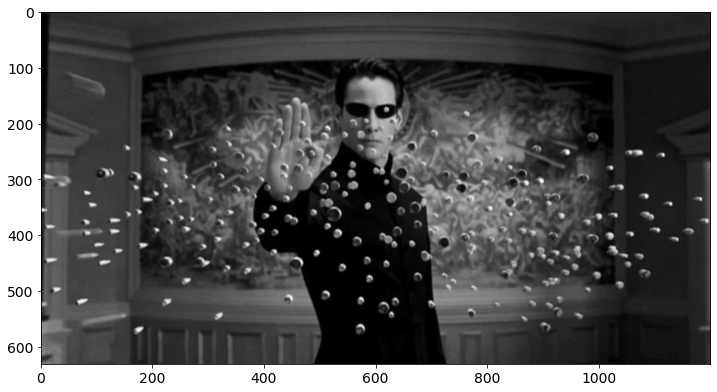

In [12]:
nice_pic = np.array(Image.open('../week1/images/neo.png').convert('L'))
plt.imshow(nice_pic, cmap='gray');

In [13]:
U, s, V = svd(nice_pic)
print((U.shape, s.shape, V.shape))

((631, 631), (631,), (1200, 1200))


In [14]:
S = np.zeros(nice_pic.shape)
S[:len(s), :len(s)] = np.diag(s)
print(S.shape)
S

(631, 1200)


array([[52080.85,     0.  ,     0.  , ...,     0.  ,     0.  ,     0.  ],
       [    0.  , 14336.99,     0.  , ...,     0.  ,     0.  ,     0.  ],
       [    0.  ,     0.  ,  8300.81, ...,     0.  ,     0.  ,     0.  ],
       ...,
       [    0.  ,     0.  ,     0.  , ...,     0.  ,     0.  ,     0.  ],
       [    0.  ,     0.  ,     0.  , ...,     0.  ,     0.  ,     0.  ],
       [    0.  ,     0.  ,     0.  , ...,     0.  ,     0.  ,     0.  ]])

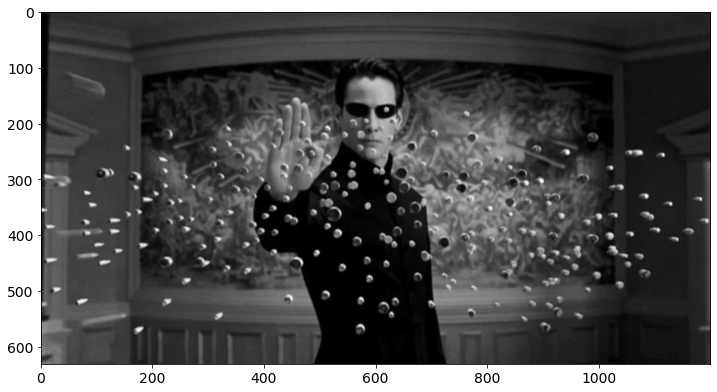

In [15]:
plt.imshow(U @ S @ V, cmap='gray');

In [16]:
def reshape_for_k(k: int, U, s, V):
    U_new = U[: , :k]
    S = np.zeros((U.shape[0], V.shape[1]))
    S[:len(s), :len(s)] = np.diag(s)
    S_new = S[: k, : k]
    V_new = V[: k, :]
    return U_new @ S_new @ V_new

In [17]:
@interact(k=widgets.IntSlider(min=1,max=631,step=10,value=10))
def plot_figure(k):
    plt.title(f'k = {k}')
    new_img = reshape_for_k(k, U, s, V)
    plt.imshow(new_img, cmap='gray')

interactive(children=(IntSlider(value=10, description='k', max=631, min=1, step=10), Output()), _dom_classes=(…

## Hands-on рекомендательной системы на MF

Попробуем применить SVD на табличных данных для задачи рекомендации. Возьмем датасет из пользователей и фильмов.

In [18]:
ratings = pd.read_csv('ratings.csv')
ratings

,userId,movieId,rating,timestamp,title
0,0,1811,2.0,1260759108,Antz
1,0,1958,2.5,1260759113,The Fly
2,0,2920,3.0,1260759117,Blazing Saddles
3,0,1079,3.5,1260759125,Dracula
4,0,1083,2.0,1260759131,Cape Fear
...,...,...,...,...,...
99845,670,2622,4.0,1070940360,Of Mice and Men
99846,670,4588,4.0,1070940363,The Matrix Reloaded
99847,670,4601,2.5,1070979663,Whale Rider
99848,670,4687,3.5,1074784724,Seabiscuit


In [19]:
num_users, num_movies = ratings.userId.nunique(), ratings.movieId.nunique()
num_users, num_movies

(671, 9025)

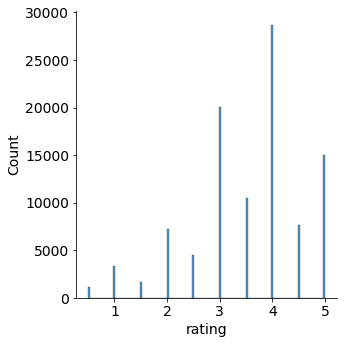

In [27]:
sns.displot(ratings.rating);

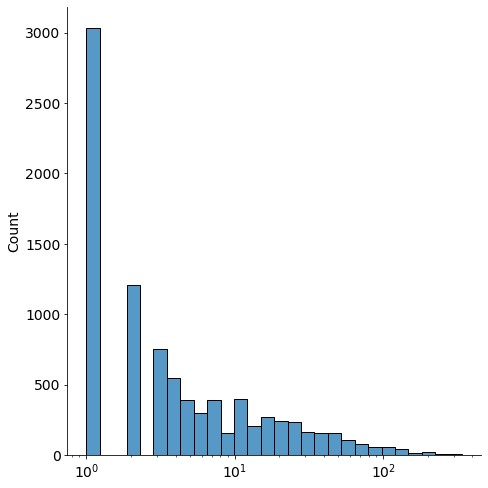

In [28]:
sns.displot(ratings.groupby('movieId').size(), log_scale=True, height=7);

Разделим выборку на обучение и тест следующим образом: для каждого пользователя в тестовую выборку попадут 10 его последних оценок.

In [20]:
train_ratings, test_ratings = [], []
num_test_samples = 10

for userId, user_data in ratings.groupby('userId'):
    train_ratings += [user_data[:-num_test_samples]]
    test_ratings += [user_data[-num_test_samples:]]

train_ratings = pd.concat(train_ratings)
test_ratings = pd.concat(test_ratings)
train_ratings.shape, test_ratings.shape

((93140, 5), (6710, 5))

In [21]:
user_encoder, item_encoder = LabelEncoder(), LabelEncoder()
train_ratings['userId'] = user_encoder.fit_transform(train_ratings['userId'])
train_ratings['movieId'] = item_encoder.fit_transform(train_ratings['movieId'])


user_ids = np.array(train_ratings['userId'].tolist())
movie_ids = np.array(train_ratings['movieId'].tolist())
user_ratings = np.array(train_ratings["rating"].tolist())
print ('num of users:',train_ratings['userId'].nunique())
print ('num of movies:',train_ratings['movieId'].nunique())

num of users: 671
num of movies: 8825


In [22]:
R = scs.coo_array((train_ratings.rating, (train_ratings.userId, train_ratings.movieId)), 
                       shape=(num_users, num_movies)).tocsr()
matrix = R.toarray()

In [23]:
U, s, V = svd(matrix)
U.shape, s.shape, V.shape

((671, 671), (671,), (9025, 9025))

In [24]:
S = np.zeros(matrix.shape)
S[:len(s), :len(s)] = np.diag(s)
print(S.shape)
S

(671, 9025)


array([[504.31,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  , 237.72,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  , 195.98, ...,   0.  ,   0.  ,   0.  ],
       ...,
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]])

In [35]:
preds_matrix = U @ S @ V

In [36]:
preds_matrix

array([[-0.,  0., -0., ...,  0.,  0.,  0.],
       [-0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [-0.,  0., -0., ...,  0.,  0.,  0.],
       [ 5., -0.,  0., ...,  0.,  0.,  0.]])

In [37]:
np.allclose(matrix, preds_matrix)

True

In [38]:
k = 20
df = pd.DataFrame(data=(zip(matrix[0, :], preds_matrix[0, :])), 
                  columns=['init', 'preds']).sort_values(by='init', ascending=False)
df['preds'] = df['preds'].astype('float32')
df.sort_values(by='preds', ascending=False).head(k)

,init,preds
1649,4.0,4.000000e+00
1072,3.5,3.500000e+00
2900,3.0,3.000000e+00
1100,2.5,2.500000e+00
1944,2.5,2.500000e+00
30,2.5,2.500000e+00
1006,2.0,2.000000e+00
1076,2.0,2.000000e+00
1036,2.0,2.000000e+00
1798,2.0,2.000000e+00


Посмотрим, как это работает, если оптимизировать функцию и итеративно уменьшать ошибку

$prediction = user\_embedding[userId] \cdot movie\_embedding[movieId] + user\_bias[userId] + movie\_bias[movieId] + global\_bias$


Функция потерь (L):

минимизируем ошибку, добавив регуляризацию и bias компоненту:

$||prediction - rating||^2 + \lambda (||user\_embedding||^2 + ||movie\_embedding||^2 + ||user\_bias||^2 + ||movie\_bias||^2)$

$\lambda$ - регуляризация. 
L2 loss. 

In [37]:
n_movie = train_ratings.movieId.nunique() #8825
n_user = train_ratings.userId.nunique() # 671

embedding_size = 10
lr = 0.001
reg = 0.01

In [38]:
user_ids = torch.LongTensor(train_ratings['userId'].values)
movie_ids = torch.LongTensor(train_ratings['movieId'].values)
user_ratings = torch.FloatTensor(train_ratings['rating'].values)

In [39]:
class MatrixFactorization(nn.Module):
    
    def __init__(self, n_user, n_movie, embedding_size):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(n_user, embedding_size)
        self.movie_embedding = nn.Embedding(n_movie, embedding_size)
        self.user_bias_embedding = nn.Embedding(n_user, 1)
        self.movie_bias_embedding = nn.Embedding(n_movie, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))

    def forward(self, user, movie):
        u = self.user_embedding(user)
        m = self.movie_embedding(movie)
        u_bias = self.user_bias_embedding(user).squeeze()
        m_bias = self.movie_bias_embedding(movie).squeeze()
        predicted_rating = torch.sum(u * m, dim=1) + u_bias + m_bias + self.global_bias
        return predicted_rating

In [40]:
model = MatrixFactorization(n_user, n_movie, embedding_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

In [41]:
batch_size = 16
n_epoch = 3

for epoch in range(n_epoch):
    for start in range(0, len(user_ratings) - batch_size, batch_size):
        end = start + batch_size
        user_batch = user_ids[start:end]
        movie_batch = movie_ids[start:end]
        rating_batch = user_ratings[start:end]

        optimizer.zero_grad()
        outputs = model(user_batch, movie_batch)
        loss = criterion(outputs, rating_batch)
        loss.backward()
        optimizer.step()

    print("RMSE", torch.sqrt(loss).item())

# Access the embeddings
movie_embeddings = model.movie_embedding.weight.detach().numpy()

RMSE 0.6754335761070251
RMSE 0.6437369585037231
RMSE 0.6400254964828491


**Truncated SVD**


Можно взять только часть компонент. Например, первые 10 компонент матрицы фильма пользователя x, созданные посредством усеченного SVD. В реконструированной матрице присутствуют скрытые признаки, показывающие корреляцию с оценками пользователей для прогнозирования рейтинга.

In [44]:
R = pd.pivot_table(ratings, values='rating', index=['userId'],columns=['movieId'], fill_value=0).to_numpy()
print ('{0}x{1} user by user matrix'.format(*R.shape))

671x9025 user by user matrix


In [48]:
train_user = R[:500, :1200]
test_user = R[500:, 1200:]

In [49]:
from sklearn.decomposition import TruncatedSVD

user_svd = TruncatedSVD(n_components=10)
user_features = user_svd.fit_transform(train_user)

print ("user_features.shape = {0}".format(user_features.shape))

user_features.shape = (500, 10)


In [50]:
tsne = TSNE(perplexity=5, n_components=3, init="pca", n_iter=1000)
plot_only = 15
coords_3d = tsne.fit_transform(user_features[:plot_only, :])

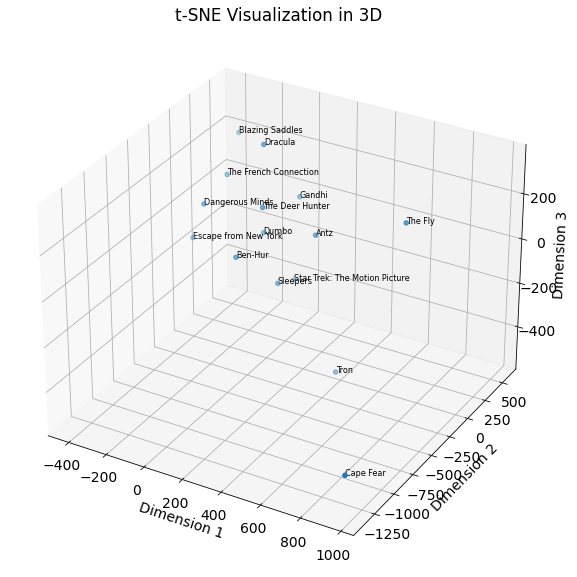

In [51]:
# Create DataFrame for 3D visualization
df_tsne_3d = pd.DataFrame(coords_3d, columns=['tsne_1', 'tsne_2', 'tsne_3'])

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_tsne_3d['tsne_1'], df_tsne_3d['tsne_2'], df_tsne_3d['tsne_3'])

for i, txt in enumerate(ratings['title'].iloc[:plot_only]):
    ax.text(df_tsne_3d['tsne_1'][i], df_tsne_3d['tsne_2'][i], df_tsne_3d['tsne_3'][i], '%s' % (txt), size=8, zorder=1)

ax.set_title('t-SNE Visualization in 3D')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

plt.show();

<ins>Вопросы и замечания:</ins> 

*  1. В чем может быть практическая польза хранить не исходную матрицу, а две/три новые матрицы? 

*Помним, что обычно dim << n и dim << m, таким образом, на практике нам дешевле хранить в памяти две более компактные матрицы, чем исходную*

*  2. Что важнее - сама оценка скалярного произведения или порядок между оценками?

* 3. Подойдет ли нам наиболее точная аппроксимация исходной матрицы для рекомендательных систем (т.е. полностью точно воспроизвели все значения в материце интеракций)? Почему? 